
# Análise de Sentimentos

O dataset que você está utilizando é uma coleção robusta de 8.100 reviews de clientes de companhias aéreas, ideal para uma análise detalhada de Experiência do Cliente (CX) e Reputação de Marca.
1. Fonte e Volume (O Escopo)
 * Volume: O conjunto de dados contém 8.100 entradas ou reviews.
 * Natureza: Cada entrada é uma avaliação de serviço de companhias aéreas, combinando dados quantitativos (notas) e qualitativos (texto).
 * Tempo: O arquivo inclui reviews datadas, com registros visíveis que chegam até, pelo menos, março de 2024, indicando que a análise está sendo feita sobre dados bastante recentes.
2. Variáveis Chave (A Visão 360º)
O dataset é particularmente rico, pois mistura texto livre com dados categóricos e numéricos, permitindo análises preditivas avançadas.
| Tipo de Dado | Variável (Coluna) | O que Representa para o Negócio |
|---|---|---|
| Qualitativo (Texto) | Reviews e Title | A Voz Bruta do Cliente (O foco do VADER e LDA). |
| Quantitativo (Notas) | Overall Rating, Seat Comfort, Staff Service, Food & Beverages, etc. | O Nível de Satisfação Detalhada (Permite quantificar a dor em áreas específicas). |
| Decisão (Alvo) | Recommended (Sim/Não) | A Métrica Final de Lealdade (O objetivo principal para futuras modelagens preditivas). |
| Segmentação (Filtro) | Airline, Type of Traveller, Class, Verified | Os Filtros Estratégicos (Permitem identificar, por exemplo, se a Business Class tem problemas de comida diferentes da Economy). |
3. Conclusão Contextual (A Vantagem)
Este dataset permite ir além de simplesmente dizer "o sentimento é negativo". Ele permite uma Análise Prescritiva. Você pode:
 * Diagnosticar (via LDA): O que está sendo falado (Tópicos).
 * Medir a Dor (via VADER): Quão ruim é o que está sendo falado.
 * Priorizar (via Segmentação): Onde o problema é mais grave (Qual companhia, qual tipo de viajante).
Oráculo DataFlow, para continuarmos na sua trilha, qual o próximo desafio?
 * Plano de Ação: Criamos um plano de resposta tático para a Turkish Airlines com base na SRO_WATCH_LIST (abordagem Operacional)?
 * Modelo Preditivo: Desenvolvemos um plano para construir um modelo de Machine Learning que preveja se um cliente irá Recomendar (1/0) a companhia, usando todas as variáveis que você preparou (abordagem Técnica Avançada)?

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Configuração do ambiente e carregamento das ferramentas (Pandas, NLTK, sklearn) e dos dados. Garantido a importação de todas as ferramentas necessárias que serão utilizadas no decorrer do projeto.

In [ ]:
import pandas as pd
from datetime import datetime
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import MinMaxScaler
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import re
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Assumindo que seu DataFrame de reviews limpos se chama 'df'

Carregando o Dataset que será utilizado e realizando a análise Exploratória do dataset

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/01 - Organização Pessoal/Estudos /Estágio /data_science_portfolio/mini_projects/Airlines_sentimental_review/data/raw/airlines_reviews.csv')

In [ ]:
df.head(1)

,Title,Name,Review Date,Airline,Verified,Reviews,Type of Traveller,Month Flown,Route,Class,Seat Comfort,Staff Service,Food & Beverages,Inflight Entertainment,Value For Money,Overall Rating,Recommended
0,Flight was amazing,Alison Soetantyo,2024-03-01,Singapore Airlines,True,Flight was amazing. The crew onboard this fl...,Solo Leisure,December 2023,Jakarta to Singapore,Business Class,4,4,4,4,4,9,yes


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8100 entries, 0 to 8099
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Title                   8100 non-null   object
 1   Name                    8100 non-null   object
 2   Review Date             8100 non-null   object
 3   Airline                 8100 non-null   object
 4   Verified                8100 non-null   object
 5   Reviews                 8100 non-null   object
 6   Type of Traveller       8100 non-null   object
 7   Month Flown             8100 non-null   object
 8   Route                   8100 non-null   object
 9   Class                   8100 non-null   object
 10  Seat Comfort            8100 non-null   int64 
 11  Staff Service           8100 non-null   int64 
 12  Food & Beverages        8100 non-null   int64 
 13  Inflight Entertainment  8100 non-null   int64 
 14  Value For Money         8100 non-null   int64 
 15  Over

Convertendo a coluna 'Review Date'

In [ ]:
df['Review Date'] = pd.to_datetime(df['Review Date'])

Limpeza de ruído e padronização coluna 'Verified'. Variantes como *Unverified* e NotVerified são unificadas para False, e depois convertidas para 1 e 0 (Booleano), para facilitar a análise e futuros modelos de regressão (ex: "A verificação influencia o rating?").

Valores que fogem dessa variável foi excluída.

Estamos padronizando a confiança. Se o dado é para tomada de decisão, precisamos que 'Verificado' seja uma categoria limpa e numérica (1/0) para medir a credibilidade de cada review."

In [ ]:
df['Verified'].value_counts()

,count
Verified,
True,6216
False,1881
*Unverified*,1
NotVerified,1
we do appreciate you bringing this matter to our attention. Please accept my apologies for not having met your expectations; I do hope that we can leave you and your family with a more positive impression on your future flights with us,1


In [ ]:
df['Verified'] = df['Verified'].replace({
    '*Unverified*': 'False',
    'NotVerified': 'False'
})

In [ ]:
df.drop(df[~df['Verified'].isin(['True', 'False'])].index, inplace=True)

In [ ]:
df['Verified'] = df['Verified'].map({'True': 1, 'False': 0})

df['Verified'] = df['Verified'].astype(bool)

Verificando as variantes da coluna 'Type of Traveller'

In [ ]:
df['Type of Traveller'].value_counts()

,count
Type of Traveller,
Solo Leisure,3237
Couple Leisure,1898
Family Leisure,1551
Business,1413


Transformar strings de data (Month Flown) em objetos datetime para permitir análises temporais. Conversão de Recommended para 1/0.

Estamos criando uma Linha do Tempo Estratégica. Agora podemos monitorar o sentimento ao longo dos meses e anos, identificando se a reputação está melhorando ou piorando no tempo e quão recomendável é nossa companhia.

In [ ]:
df['Month Flown'] = pd.to_datetime(df['Month Flown'], format='%B %Y')

In [ ]:
df['Month Flown'].head()

,Month Flown
0,2023-12-01
1,2024-02-01
2,2024-02-01
3,2024-02-01
4,2024-02-01


In [ ]:

df['Year Flown'] = df['Month Flown'].dt.year   # ex: 2023
df['Month Flown'] = df['Month Flown'].dt.month # ex: 12

Assim como nas colunas anteriores, os valores padronizados e convertidos em bool para futura análises.

In [ ]:
df['Recommended'].value_counts()

,count
Recommended,
yes,4287
no,3812


In [ ]:
df['Recommended'] = df['Recommended'].map({'Yes': 1, 'No': 0})

df['Recommended'] = df['Recommended'].astype(bool)

Padronizar as colunas do tipo object para string

In [ ]:

df_text = df.select_dtypes(include=['object']).columns

df[df_text] = df[df_text].astype('string')

In [ ]:
df.head()

,Title,Name,Review Date,Airline,Verified,Reviews,Type of Traveller,Month Flown,Route,Class,Seat Comfort,Staff Service,Food & Beverages,Inflight Entertainment,Value For Money,Overall Rating,Recommended,Year Flown
0,Flight was amazing,Alison Soetantyo,2024-03-01,Singapore Airlines,True,Flight was amazing. The crew onboard this fl...,Solo Leisure,12,Jakarta to Singapore,Business Class,4,4,4,4,4,9,True,2023
1,seats on this aircraft are dreadful,Robert Watson,2024-02-21,Singapore Airlines,True,Booking an emergency exit seat still meant h...,Solo Leisure,2,Phuket to Singapore,Economy Class,5,3,4,4,1,3,True,2024
2,Food was plentiful and tasty,S Han,2024-02-20,Singapore Airlines,True,Excellent performance on all fronts. I would...,Family Leisure,2,Siem Reap to Singapore,Economy Class,1,5,2,1,5,10,True,2024
3,“how much food was available,D Laynes,2024-02-19,Singapore Airlines,True,Pretty comfortable flight considering I was f...,Solo Leisure,2,Singapore to London Heathrow,Economy Class,5,5,5,5,5,10,True,2024
4,“service was consistently good”,A Othman,2024-02-19,Singapore Airlines,True,The service was consistently good from start ...,Family Leisure,2,Singapore to Phnom Penh,Economy Class,5,5,5,5,5,10,True,2024


Verificando os valores das colunas numéricas

In [ ]:
# Apenas inteiros
df_int = df.select_dtypes(include=['int64'])

df_int.describe()

,Seat Comfort,Staff Service,Food & Beverages,Inflight Entertainment,Value For Money,Overall Rating
count,8099.000000,8099.000000,8099.000000,8099.000000,8099.000000,8099.000000
mean,3.414990,3.569700,3.383998,3.636745,3.148907,5.632918
std,1.397181,1.527447,1.455768,1.309638,1.589296,3.523650
min,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,2.000000,2.000000,2.000000,3.000000,1.000000,2.000000
50%,4.000000,4.000000,4.000000,4.000000,3.000000,6.000000
75%,5.000000,5.000000,5.000000,5.000000,5.000000,9.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,10.000000


Foi identificado que a coluna 'Inflight Entertainment' possui o valor mínimo de 0, para padronizar com demais colunas, foi substituído 0 por 1 que é a menor avaliação possível.

In [ ]:
df['Inflight Entertainment'] = df['Inflight Entertainment'].replace(0, 1)

Padronizar as colunas de rating (Seat Comfort, Food & Beverages, etc.) para que fiquem todas na mesma escala (0 a 1). Isso é crucial para modelos de Machine Learning futuros, garantindo que nenhuma variável domine o modelo apenas por ter números maiores.

Estamos equilibrando a balança. Garantimos que todos os critérios de serviço, como 'Conforto do Assento' e 'Serviço da Tripulação', tenham o mesmo peso matemático na análise, independentemente de como foram inicialmente pontuados.

In [ ]:
numeric_cols = df_int.columns

scaler = MinMaxScaler()

df[numeric_cols] = scaler.fit_transform(df_int)

df.head()

,Title,Name,Review Date,Airline,Verified,Reviews,Type of Traveller,Month Flown,Route,Class,Seat Comfort,Staff Service,Food & Beverages,Inflight Entertainment,Value For Money,Overall Rating,Recommended,Year Flown
0,Flight was amazing,Alison Soetantyo,2024-03-01,Singapore Airlines,True,Flight was amazing. The crew onboard this fl...,Solo Leisure,12,Jakarta to Singapore,Business Class,0.75,0.75,0.75,0.8,0.75,0.888889,True,2023
1,seats on this aircraft are dreadful,Robert Watson,2024-02-21,Singapore Airlines,True,Booking an emergency exit seat still meant h...,Solo Leisure,2,Phuket to Singapore,Economy Class,1.00,0.50,0.75,0.8,0.00,0.222222,True,2024
2,Food was plentiful and tasty,S Han,2024-02-20,Singapore Airlines,True,Excellent performance on all fronts. I would...,Family Leisure,2,Siem Reap to Singapore,Economy Class,0.00,1.00,0.25,0.2,1.00,1.000000,True,2024
3,“how much food was available,D Laynes,2024-02-19,Singapore Airlines,True,Pretty comfortable flight considering I was f...,Solo Leisure,2,Singapore to London Heathrow,Economy Class,1.00,1.00,1.00,1.0,1.00,1.000000,True,2024
4,“service was consistently good”,A Othman,2024-02-19,Singapore Airlines,True,The service was consistently good from start ...,Family Leisure,2,Singapore to Phnom Penh,Economy Class,1.00,1.00,1.00,1.0,1.00,1.000000,True,2024


Instalamos nosso Radar de Emoções. O VADER nos permite fazer uma triagem de 8100 reviews em segundos, separando o que é 'Dor' (Negativo), o que é 'Sucesso' (Positivo) e o que é neutro, para podermos focar a auditoria onde o impacto é maior.

VADER (Valence Aware Dictionary and sEntiment Reasoner) é um léxico pré-treinado otimizado para mídias sociais e reviews. É extremamente rápido e eficaz para uma primeira leitura de sentimento.

In [ ]:
# Configuração e Inicialização
try:
    nltk.data.find('sentiment/vader_lexicon.zip')
except:
    nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:

# Função de Classificação
def classificar_sentimento(texto):
    # Trata valores não-string que podem ter passado na limpeza
    if not isinstance(texto, str):
        return 'Neutro'

    # O VADER retorna uma pontuação 'compound' entre -1 (Extremamente Negativo) e +1 (Extremamente Positivo)
    score = sia.polarity_scores(texto)
    compound_score = score['compound']

    if compound_score >= 0.05:
        return 'Positivo'
    elif compound_score <= -0.05:
        return 'Negativo'
    else:
        return 'Neutro'

Este é o nosso Placar Inicial. Ele nos diz o volume bruto de reclamações e elogios em toda a base, validando se temos dados suficientes em cada categoria para continuar a análise profunda

In [ ]:
# Aplicação e Análise


if 'Reviews' in df.columns:
    df['Sentimento'] = df['Reviews'].apply(classificar_sentimento)

    # Distribuição dos resultados
    print("Distribuição de Sentimentos (VADER)")
    print(df['Sentimento'].value_counts())
else:
    print("ERRO: Coluna 'Reviews' não encontrada no DataFrame 'df'.")

Ο CountVectorizer transforma texto em números (matriz DTM), e o LDA (Latent Dirichlet Allocation) é um algoritmo de Machine Learning não supervisionado que descobre os temas ocultos nos dados.

Narrativa: "Acabamos de ativar nossa Ferramenta de Diagnóstico. Em vez de ler 8100 reviews, o LDA lê e agrupa automaticamente as reclamações em 5 Tópicos-Chave (Ex: 'Atendimento e Ticketing', 'Experiência em Voo', etc.), fornecendo o 'Porquê' por trás do sentimento."

In [ ]:


vectorizer = CountVectorizer(stop_words='english', max_df=0.9, min_df=5)
dtm = vectorizer.fit_transform(df['Reviews'])

In [ ]:


# Define e treina o modelo LDA
lda = LatentDirichletAllocation(
    n_components=5,        # número de tópicos
    random_state=42,
    learning_method='batch'
)

lda.fit(dtm)

LatentDirichletAllocation(n_components=5, random_state=42)

Vamos identificar quais tópicos extraídos pelo modelo LDA estão mais associados a sentimentos negativos nas avaliações. Primeiro, o modelo LDA transforma a matriz de documentos (DTM) em probabilidades de pertencimento a cada tópico, e para cada review é escolhido o tópico com maior probabilidade, simplificando a análise ao atribuir um único tema principal por texto. Em seguida, cada tópico recebe um nome interpretável, facilitando a leitura e a comunicação dos resultados. Com essa classificação, é criada uma tabela de contingência que cruza os tópicos com os sentimentos das avaliações, permitindo observar quantas reviews positivas, negativas ou neutras existem em cada tema. Essa tabela é então normalizada para converter as contagens em percentuais, de modo que se possa comparar a proporção de sentimentos dentro de cada tópico, independentemente do número total de avaliações. Por fim, o código ordena os tópicos pelo maior percentual de avaliações negativas e adiciona o volume total de reviews de cada um, o que possibilita priorizar temas com maior impacto. Em síntese, o raciocínio por trás desse processo é transformar resultados de modelagem de tópicos em uma análise prescritiva de experiência do cliente, destacando onde estão os principais focos de insatisfação e permitindo direcionar ações de melhoria baseadas em evidências.

In [ ]:


# --- 1. Atribuição do Tópico Mais Provável ---

# Transforma a matriz DTM (Document-Term Matrix) usando o modelo LDA treinado
# O 'dtm' e o 'lda' devem ser os objetos da execução anterior.
topic_probabilities = lda.transform(dtm)

# Encontra o índice do tópico com a maior probabilidade para cada review
# O resultado é uma lista de índices (0, 1, 2, 3 ou 4)
df['Topico_ID'] = topic_probabilities.argmax(axis=1)

# Mapeia o ID para o nome interpretado (para facilitar a leitura)
topic_mapping = {
    0: 'Atendimento e Ticketing',
    1: 'Experiência em Voo (Assento/Comida)',
    2: 'Qatar/Doha (Hub e Serviço)',
    3: 'Problemas em Solo (Atrasos/Aeroporto)',
    4: 'Rotas/Aéreas Específicas (AF/EVA)'
}
df['Topico_Principal'] = df['Topico_ID'].map(topic_mapping)

# --- 2. Criação da Tabela de Contingência (Sentimento vs. Tópico) ---

# Gera uma tabela cruzada de contagens (Tópico x Sentimento)
contingency_table = pd.crosstab(df['Topico_Principal'], df['Sentimento'])

# --- 3. Normalização para Análise (Percentual Negativo) ---

# Calcula o percentual de cada sentimento DENTRO de cada tópico
topic_sentiment_pct = contingency_table.div(contingency_table.sum(axis=1), axis=0) * 100

print("\n--- Tabela de Análise Prescritiva: % Sentimento por Tópico ---")
# Exibe apenas as colunas 'Negativo' e 'Total de Reviews'
analysis_final = topic_sentiment_pct[['Negativo']].sort_values(by='Negativo', ascending=False)
analysis_final['Total_Reviews'] = contingency_table.sum(axis=1)

print(analysis_final.to_markdown())


--- Tabela de Análise Prescritiva: % Sentimento por Tópico ---
| Topico_Principal                      |   Negativo |   Total_Reviews |
|:--------------------------------------|-----------:|----------------:|
| Experiência em Voo (Assento/Comida)   |   71.4993  |            1414 |
| Rotas/Aéreas Específicas (AF/EVA)     |   71.1493  |            1279 |
| Atendimento e Ticketing               |   50.266   |             376 |
| Qatar/Doha (Hub e Serviço)            |   24.7809  |            2853 |
| Problemas em Solo (Atrasos/Aeroporto) |    7.62517 |            2177 |


Cada review agora tem um Rótulo de Causa. Isso transforma dados brutos em informação acionável, permitindo que o time de Operações saiba exatamente a qual setor enviar cada reclamação.

In [ ]:
# Rabela de contagem (topicos x Sentimento )

contingency_table = pd.crosstab(df['Topico_Principal'], df['Sentimento'])
print("\n--- Tabela de Contingência (Tópicos x Sentimento) ---")
print(contingency_table)


--- Tabela de Contingência (Tópicos x Sentimento) ---
Sentimento                             Negativo  Neutro  Positivo
Topico_Principal                                                 
Atendimento e Ticketing                     189       8       179
Experiência em Voo (Assento/Comida)        1011      22       381
Problemas em Solo (Atrasos/Aeroporto)       166      14      1997
Qatar/Doha (Hub e Serviço)                  707      34      2112
Rotas/Aéreas Específicas (AF/EVA)           910      30       339


Esta é nossa Matriz de Risco Crítico. O tópico 'Experiência em Voo' tem 71.50% de reviews negativos. Isso significa que é o problema mais virulento. Se quisermos o maior impacto com o menor esforço, atacamos este tópico primeiro.


Estamos olhando para a Severidade do Problema. O tópico 'Experiência em Voo' é o mais negativo (71.50%) e tem um volume alto (1414 reviews), tornando-o nosso Alvo Tático #1.

In [43]:
# DataFrame de priorizaçao (Metricas por Topico)

df_priorizacao = pd.DataFrame(index=contingency_table.index)

# Metrica de escala
df_priorizacao['Total_Reviews_no_Topico'] =  contingency_table.sum(axis=1)

# Metricas de Intensidae (O mais importante)
# calcula a porcentagem de negativos sobre o total de reviews daquele tópico
df_priorizacao['Percentual_Negativo'] =( contingency_table['Negativo'] / df_priorizacao['Total_Reviews_no_Topico'] )* 100

# Metrica de Saúde
df_priorizacao['Percentual_Positivos'] =  (
    contingency_table['Positivo'] / df_priorizacao['Total_Reviews_no_Topico']
) * 100

# Classificação final (Gráfico de Barras)
df_priorizacao =  df_priorizacao.sort_values(by='Percentual_Negativo', ascending=False)

print("\n--- DataFrame de Priorização (Metricas por Tópico) ---")
print(df_priorizacao.to_markdown(floatfmt=".2f"))


--- DataFrame de Priorização (Metricas por Tópico) ---
| Topico_Principal                      |   Total_Reviews_no_Topico |   Percentual_Negativo |   Percentual_Positivos |
|:--------------------------------------|--------------------------:|----------------------:|-----------------------:|
| Experiência em Voo (Assento/Comida)   |                   1414.00 |                 71.50 |                  26.94 |
| Rotas/Aéreas Específicas (AF/EVA)     |                   1279.00 |                 71.15 |                  26.51 |
| Atendimento e Ticketing               |                    376.00 |                 50.27 |                  47.61 |
| Qatar/Doha (Hub e Serviço)            |                   2853.00 |                 24.78 |                  74.03 |
| Problemas em Solo (Atrasos/Aeroporto) |                   2177.00 |                  7.63 |                  91.73 |


Aplicamos o Foco Cirúrgico. Queremos saber: Quem está mais insatisfeito (Família Lazer, 76.82% Negativo)? Onde está a maior falha (Turkish Airlines, 82.28% Negativo)? Onde concentrar a melhoria (Economy Class, 72.12% Negativo)? Estes são nossos segmentos de clientes mais vulneráveis."

In [ ]:
COLUNAS_SEGMENTACAO = ['Class', 'Type of Traveller', 'Airline']
TOPICO_ALVO = 'Experiência em Voo (Assento/Comida)' # Use o nome exato da tabela anterior

print("\n--- Análise Quantitativa: % Negativo no Tópico 1 por Segmento ---")

# Filtra apenas as reviews do Tópico 1
df_topico_1 = df[df['Topico_Principal'] == TOPICO_ALVO]

for col in COLUNAS_SEGMENTACAO:
    if col in df_topico_1.columns:
        # Tabela cruzada de Contagem (Segmento x Sentimento)
        crosstab_seg = pd.crosstab(df_topico_1[col], df_topico_1['Sentimento'])

        # Normaliza para calcular o % Negativo dentro de cada segmento
        segment_pct = crosstab_seg.div(crosstab_seg.sum(axis=1), axis=0) * 100

        print(f"\nResultados para a coluna: {col}")

        analise_segmento = segment_pct[['Negativo']].sort_values(by='Negativo', ascending=False)

        # Filtra para exibir apenas categorias com um volume mínimo de reviews (evita ruído)
        min_reviews = 50
        total_por_segmento = crosstab_seg.sum(axis=1)
        segmentos_relevantes = total_por_segmento[total_por_segmento >= min_reviews].index

        analise_segmento_relevante = analise_segmento.loc[analise_segmento.index.intersection(segmentos_relevantes)]

        print(analise_segmento_relevante.head(5).to_markdown(floatfmt=".2f"))
    else:
        print(f"Aviso: Coluna '{col}' não encontrada no DataFrame para segmentação.")


--- Análise Quantitativa: % Negativo no Tópico 1 por Segmento ---

Resultados para a coluna: Class
| Class          |   Negativo |
|:---------------|-----------:|
| Economy Class  |      72.12 |
| Business Class |      70.12 |

Resultados para a coluna: Type of Traveller
| Type of Traveller   |   Negativo |
|:--------------------|-----------:|
| Family Leisure      |      76.82 |
| Couple Leisure      |      72.05 |
| Business            |      71.89 |
| Solo Leisure        |      67.83 |

Resultados para a coluna: Airline
| Airline                |   Negativo |
|:-----------------------|-----------:|
| Turkish Airlines       |      82.28 |
| Emirates               |      74.75 |
| Cathay Pacific Airways |      71.13 |
| Air France             |      68.63 |
| Qatar Airways          |      63.50 |


Após identificar o Tópico e a Companhia mais crítica, fazemos um drill-down qualitativo com WordCloud para obter palavras-chave acionáveis (ex: seat, food, delay). A SRO_WATCH_LIST é a consolidação dessas palavras em um Sistema de Alerta de Risco Operacional (SRO).
Transformamos a queixa em Alerta Operacional em Tempo Real. As 7 palavras mais citadas (Ex: flight, luggage, airport) são agora o nosso Sensor de Risco. Se uma review nova mencionar essas palavras, acionamos um protocolo de intervenção imediata, protegendo a empresa antes que o problema escale.

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


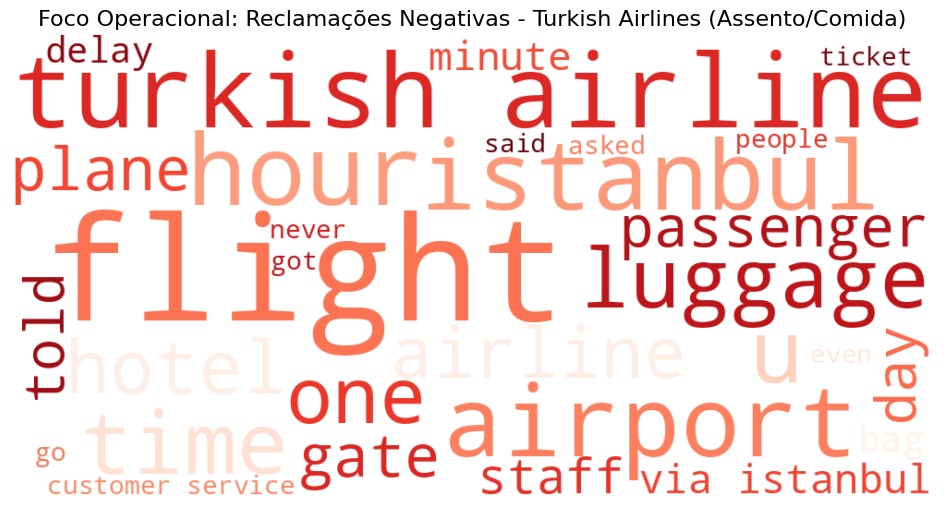


--- 7 Palavras-Chave de Reclamação - Turkish Airlines ---
['flight', 'turkish airline', 'airport', 'hour', 'istanbul', 'u', 'time']


In [ ]:
# Baixar recursos necessários se ainda não o fez (evita erro)
try:
    nltk.data.find('corpora/wordnet')
    nltk.data.find('corpora/stopwords')
except:
    nltk.download('wordnet')
    nltk.download('stopwords')


# --- 1. Definindo as variáveis de Foco ---
TOPICO_ALVO = 'Experiência em Voo (Assento/Comida)'
COMPANHIA_ALVO = 'Turkish Airlines'
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# --- 2. Função de Pré-processamento Otimizada para WordCloud ---
def preprocess_text_wc(text):
    if not isinstance(text, str):
        return ''
    # 1. Remover caracteres especiais e converter para minúsculas
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A).lower().strip()
    # 2. Tokenização, Stop Word Removal, e Lemmatização
    tokens = [lemmatizer.lemmatize(token) for token in text.split() if token not in stop_words]
    return ' '.join(tokens)


# --- 3. Filtro Cirúrgico ---
# Filtra: Apenas Negativos E Tópico 1 E Turkish Airlines
textos_auditoria = df[
    (df['Sentimento'] == 'Negativo') &
    (df['Topico_Principal'] == TOPICO_ALVO) &
    (df['Airline'] == COMPANHIA_ALVO)
]['Reviews'] # Pegamos a coluna 'Reviews' (bruta) e limpamos agora.

# 4. Aplica a limpeza e concatena
texto_completo = ' '.join(textos_auditoria.apply(preprocess_text_wc))

# 5. Gera a Nuvem de Palavras
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='white',
    colormap='Reds_r', # Cores de alerta
    max_words=30 # Focando nas 30 mais relevantes
).generate(texto_completo)

# 6. Exibe o resultado e extrai as Top 7 palavras-chave
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title(f'Foco Operacional: Reclamações Negativas - {COMPANHIA_ALVO} (Assento/Comida)', fontsize=16)
plt.show()

# Extração das palavras-chave (Qualitativa)
frequencias = wordcloud.words_.keys()
palavras_chave = list(frequencias)[:7]

print(f"\n--- 7 Palavras-Chave de Reclamação - {COMPANHIA_ALVO} ---")
print(palavras_chave)

Criamos um Termômetro de Satisfação do Cliente utiliza o Score de Risco Operacional (SRO) para monitorar automaticamente os reviews e identificar potenciais falhas de serviço, atrasos, desconfortos ou atitudes negativas. A metodologia baseia-se em uma watch-list de palavras-chave associadas a riscos operacionais, de produto e de atendimento. Cada texto é limpo, lematizado e filtrado por stopwords, garantindo que variações linguísticas, como “delayed” e “delay”, sejam tratadas de forma equivalente. Em seguida, a função calculate_sro soma um ponto para cada termo de risco presente — considerando apenas a presença única das palavras, e não sua repetição — o que torna a métrica mais estável e interpretável. O resultado é uma pontuação simples, transparente e de fácil validação, que permite identificar rapidamente os reviews com maior probabilidade de conter reclamações relevantes, priorizando ações corretivas e análises de causas-raiz de insatisfação.

In [ ]:
# --- 1. CONFIGURAÇÃO E WATCH-LIST ---
try:
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
except:
    # Baixar NLTK se necessário
    nltk.download('wordnet')
    nltk.download('stopwords')
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

# Watch-List Consolidada (15 Palavras-Chave)
SRO_WATCH_LIST = {
    'hour', 'istanbul', 'time', 'delay', 'airport', 'gate', # Risco Operacional (Causa Raiz)
    'seat', 'food', 'small', 'cold', 'dirty', 'bad',         # Risco de Produto (Foco da Reclamação)
    'terrible', 'rude', 'crew'                               # Risco de Atitude/Serviço
}

# Função de Pré-processamento (Retorna os tokens limpos para contagem)
def preprocess_text_sro(text):
    if not isinstance(text, str):
        return []
    # 1. Limpeza
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A).lower().strip()
    # 2. Tokenização e Lemmatização (Retirada de stop words)
    tokens = [lemmatizer.lemmatize(token) for token in text.split() if token not in stop_words]
    return tokens

# --- 2. FUNÇÃO DE CÁLCULO DO SRO ---
def calculate_sro(tokens):
    score = 0
    # Usar 'set(tokens)' garante que uma palavra só conte 1x por review (presença)
    # Ex: "food food food" conta 1 ponto.
    for token in set(tokens):
        if token in SRO_WATCH_LIST:
            score += 1
    return score

# --- 3. IMPLEMENTAÇÃO NO DATAFRAME ---

# 3.1. Pré-processa o texto para obter os tokens (apenas se 'Reviews_Tokens' não existir)
if 'Reviews_Tokens' not in df.columns:
    df['Reviews_Tokens'] = df['Reviews'].apply(preprocess_text_sro)

# 3.2. Calcula o Score SRO
df['SRO_Score'] = df['Reviews_Tokens'].apply(calculate_sro)

# --- 4. VERIFICAÇÃO ---
print("--- Implementação do Score de Risco Operacional (SRO) Concluída ---")
print("\nDistribuição do SRO Score (Top 5 Contagens):")
print(df['SRO_Score'].value_counts().head(5).to_markdown())

print("\nExemplo de Reviews com Alto Risco (SRO Score >= 4):")
# Filtra reviews com alto risco para demonstração
print(df[df['SRO_Score'] >= 4][['Airline', 'Sentimento', 'Reviews', 'SRO_Score']].head(3).to_markdown())

--- Implementação do Score de Risco Operacional (SRO) Concluída ---

Distribuição do SRO Score (Top 5 Contagens):
|   SRO_Score |   count |
|------------:|--------:|
|           2 |    1865 |
|           3 |    1794 |
|           1 |    1352 |
|           4 |    1295 |
|           5 |     737 |

Exemplo de Reviews com Alto Risco (SRO Score >= 4):
|    | Airline            | Sentimento   | Reviews                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         